In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.signal import correlate
import pyroomacoustics as pra
import soundfile as sf
from IPython.display import Audio
from scipy.fft import fft, ifft
from scipy.signal import correlate

import doascripts as doa
import simscripts as sim
import plotting as pt
import measuring as meas

# MIC POSITION VARIACION

In [25]:

Mic_Pos_1 = {
    "room_dim": [5, 5, 5], 
    "rt60": 0.2,
    "mic_amount": 4,
    "mic_start": [1, 1, 1],
    "mic_dist": 0.1,
    "source_pos": [2.5, 2.5, 1],
    "fs": 44100}
#Aseguro angulo de 90° en inicio

In [26]:
sim.expand_param(Mic_Pos_1, "mic_start", [0.015,0,0], n=100,  filename = "Mic_Pos1")

{'room_dim': [5, 5, 5],
 'rt60': 0.2,
 'mic_amount': 4,
 'mic_start': [[1.0, 1, 1],
  [1.015, 1, 1],
  [1.03, 1, 1],
  [1.045, 1, 1],
  [1.06, 1, 1],
  [1.075, 1, 1],
  [1.09, 1, 1],
  [1.105, 1, 1],
  [1.12, 1, 1],
  [1.135, 1, 1],
  [1.15, 1, 1],
  [1.165, 1, 1],
  [1.18, 1, 1],
  [1.195, 1, 1],
  [1.21, 1, 1],
  [1.225, 1, 1],
  [1.24, 1, 1],
  [1.255, 1, 1],
  [1.27, 1, 1],
  [1.285, 1, 1],
  [1.3, 1, 1],
  [1.315, 1, 1],
  [1.33, 1, 1],
  [1.345, 1, 1],
  [1.3599999999999999, 1, 1],
  [1.375, 1, 1],
  [1.3900000000000001, 1, 1],
  [1.405, 1, 1],
  [1.42, 1, 1],
  [1.435, 1, 1],
  [1.45, 1, 1],
  [1.4649999999999999, 1, 1],
  [1.48, 1, 1],
  [1.495, 1, 1],
  [1.51, 1, 1],
  [1.525, 1, 1],
  [1.54, 1, 1],
  [1.555, 1, 1],
  [1.5699999999999998, 1, 1],
  [1.585, 1, 1],
  [1.6, 1, 1],
  [1.615, 1, 1],
  [1.63, 1, 1],
  [1.645, 1, 1],
  [1.66, 1, 1],
  [1.6749999999999998, 1, 1],
  [1.69, 1, 1],
  [1.705, 1, 1],
  [1.72, 1, 1],
  [1.7349999999999999, 1, 1],
  [1.75, 1, 1],
  [1.7650000

Ver si al cambiar la posición del array se mantiene estable el ángulo estimado (como debería), o si algunos métodos se degradan cuando se alejan o acercan al centro.

El angulo deberia ir aumentando a medida que el microfono empieza a acercarse al centro. serian los primeros 4 metros hasta llegar a la mitad de la sala.

Como audio se utilizará un impulso

In [27]:
x,y,z = doa.full_doa_pipeline("Mic_Pos1.json","Audios/imp.wav", method="classictemp", variable_param="mic_start",return_error=False)


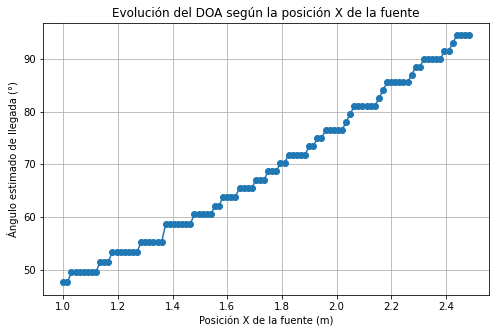

[47.56, 47.56, 49.54, 49.54, 49.54, 49.54, 49.54, 49.54, 49.54, 51.52, 51.52, 51.52, 53.35, 53.35, 53.35, 53.35, 53.35, 53.35, 53.35, 55.18, 55.18, 55.18, 55.18, 55.18, 55.18, 58.74, 58.74, 58.74, 58.74, 58.74, 58.74, 58.74, 60.46, 60.46, 60.46, 60.46, 60.46, 62.1, 62.1, 63.83, 63.83, 63.83, 63.83, 65.47, 65.47, 65.47, 65.47, 67.06, 67.06, 67.06, 68.7, 68.7, 68.7, 70.29, 70.29, 71.83, 71.83, 71.83, 71.83, 71.83, 73.42, 73.42, 74.96, 74.96, 76.48, 76.48, 76.48, 76.48, 76.48, 78.02, 79.54, 81.03, 81.03, 81.03, 81.03, 81.03, 81.03, 82.55, 84.04, 85.53, 85.53, 85.53, 85.53, 85.53, 85.53, 87.03, 88.51, 88.51, 90.0, 90.0, 90.0, 90.0, 90.0, 91.49, 91.49, 92.97, 94.47, 94.47, 94.47, 94.47]


In [28]:
x_coords = [pos[0] for pos in x] 
plt.figure(figsize=(8, 5))
plt.plot(x_coords, y, marker='o')
plt.xlabel("Posición X de la fuente (m)")
plt.ylabel("Ángulo estimado de llegada (°)")
plt.title("Evolución del DOA según la posición X de la fuente")
plt.grid(True)
plt.show()

print(y)

Perfecto, Automatizamos y observamos como se desempeñan los distintos algoritmos.

In [29]:
methods = [
    "classictemp",  # correlación cruzada directa en el dominio temporal
    "classicfft",   # correlación cruzada clásica vía FFT
    "phat",         # GCC con ponderación PHAT
    "scot",         # GCC con ponderación SCOT
    "roth",         # GCC con ponderación Roth
    "eckart",       # GCC con ponderación Eckart
    "ml"            # GCC con ponderación de máxima verosimilitud (ML)
]

In [30]:
results = {}  # Para guardar los ángulos por método

for method in methods:
    try:
        print(f"Ejecutando método: {method}")
        x, y, _ = doa.full_doa_pipeline(
            "Mic_Pos1.json", 
            "Audios/imp.wav", 
            method=method, 
            variable_param="mic_start", 
            return_error=False
        )
        x_coords = [pos[0] for pos in x]
        results[method] = (x_coords, y)
    except Exception as e:
        print(f"Error con el método {method}: {e}")

Ejecutando método: classictemp
Ejecutando método: classicfft
Ejecutando método: phat
Ejecutando método: scot
Ejecutando método: roth
Ejecutando método: eckart
Ejecutando método: ml


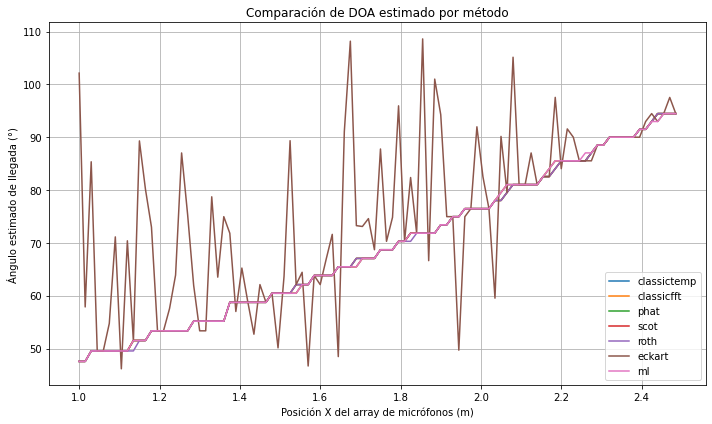

In [31]:
plt.figure(figsize=(10, 6))

for method, (x_vals, doa_vals) in results.items():
    plt.plot(x_vals, doa_vals, label=method)

plt.xlabel("Posición X del array de micrófonos (m)")
plt.ylabel("Ángulo estimado de llegada (°)")
plt.title("Comparación de DOA estimado por método")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
results2 = {}  # Para guardar los ángulos por método

for method in methods:
    try:
        print(f"Ejecutando método: {method}")
        x, y, _ = doa.full_doa_pipeline(
            "Mic_Pos1.json", 
            "Audios/imp.wav", 
            method=method, 
            variable_param="mic_start", 
            return_error=True
        )
        x_coords = [pos[0] for pos in x]
        results2[method] = (x_coords, y)
    except Exception as e:
        print(f"Error con el método {method}: {e}")

Ejecutando método: classictemp
Ejecutando método: classicfft
Ejecutando método: phat
Ejecutando método: scot
Ejecutando método: roth
Ejecutando método: eckart
Ejecutando método: ml


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))

for method, (x_coords, errors) in results2.items():
    plt.plot(x_coords, errors, label=method)

plt.xlabel("Posición X del array de micrófonos (m)")
plt.ylabel("Error (°)")
plt.title("Error de estimación del DOA por método")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

for method, (x_coords, errors) in results2.items():
    errors = np.array(errors)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    
    # Línea de error
    plt.plot(x_coords, errors, label=method)
    
    # Banda de ±1 desviación
    plt.fill_between(x_coords, errors - std_error, errors + std_error, alpha=0.2)

plt.xlabel("Posición X del array de micrófonos (m)")
plt.ylabel("Error (°)")
plt.title("Error de estimación del DOA por método (con bandas de desviación estándar)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()